In [67]:

import cv2
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [68]:
DATETIME_STR = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

PRINT_PROGRESS_EVERY_N_PERCENT = 1

ADD_TIME_TO_FILENAME = True

############### PF #############
WIDTH = 1280
HEIGHT = 720
FPS = 60

# Format from DarkLabel software: (frame_index, classname, instance_id, is_difficult, x, y, w, h) 
#                                      0            1          2            3         4  5  6  7

# Format for events: (x, y, t (us or ms), p)
EVENTS_CSV_X_COL = 0
EVENTS_CSV_Y_COL = 1
EVENTS_CSV_T_COL = 2
EVENTS_CSV_P_COL = 3

# Paths
TRAJECTORIES_CSV_DIR = Path("output/extracted_trajectories")
OUTPUT_BASE_DIR = Path("output/inspect_trajectory_hist")

EVENTS_CSV_HAS_HEADER = False
LABELS_CSV_HAS_HEADER = False

##################################

# Precision of the timestamp: for mikroseconds: 1000000, for milliseconds: 1000
TIMESTEPS_PER_SECOND = 1_000_000
# If timestamp in mikroseconds: -> mikroseconds per frame
TIMESTEPS_PER_FRAME = (1 / FPS) * TIMESTEPS_PER_SECOND
HALF_FRAME_TIME = TIMESTEPS_PER_FRAME // 2
T_SCALE = 0.002 # 0.002 is good
INV_T_SCALE = 1 / T_SCALE

T_BINS_PER_BUCKET = 250
SAVE_IMAGE_DPI = 300


np.set_printoptions(suppress=True,precision=3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


In [69]:
# Find all files from directory
# trajectory_files = TRAJECTORIES_CSV_DIR.glob("*_trajectories*/*.csv")

# trajectory_filepath = TRAJECTORIES_CSV_DIR / "hauptsächlichBienen1_trajectories_2024-05-19_12-29-00/9.csv"
trajectory_filepath = TRAJECTORIES_CSV_DIR / "1_l-l-l_trajectories_2024-05-29_15-27-12/2.csv"

In [70]:
df = pd.read_csv(trajectory_filepath, sep=',', header="infer")
print(df.head())

     x  y     t    r    g    b  is_confident
0  873  0 0.000  255  153  153             0
1  872  0 0.966  255  153  153             0
2  871  0 1.844  255  153  153             0
3  873  0 3.512  255  153  153             0
4  870  1 3.534  255  153  153             0


In [71]:
t_col_real = df.loc[:,"t"] * INV_T_SCALE
print(t_col_real.head())

max_t = t_col_real.iloc[-1]
print("max_t", max_t)

max_t_str = f"{int((max_t / TIMESTEPS_PER_SECOND) // 60):0>2}m:{(max_t / TIMESTEPS_PER_SECOND % 60):0>2.2f}s"
print("max_t_str", max_t_str)


# Biene hat 200 flügelschläge pro sek. Das sind 5ms pro flügelschlag.
# Es sollen 10 Flügelschläge in ein Fenster passen. Also 5*10=50ms oder 50000us
BUCKET_WIDTH_T = 1000 * 50
number_of_buckets = int(np.ceil(max_t/BUCKET_WIDTH_T))

print("Die Bahn hat", number_of_buckets, "buckets")

t_col_buckets = (t_col_real // BUCKET_WIDTH_T).astype('Int64')
print(t_col_buckets.head())
print(t_col_buckets.tail())

event_counts_per_bucket = t_col_buckets.value_counts(sort=False).sort_index()
print(event_counts_per_bucket.head())

0      0.000
1    483.000
2    922.000
3   1756.000
4   1767.000
Name: t, dtype: float64
max_t 7176238.0
max_t_str 00m:7.18s
Die Bahn hat 144 buckets
0    0
1    0
2    0
3    0
4    0
Name: t, dtype: Int64
1043902    143
1043903    143
1043904    143
1043905    143
1043906    143
Name: t, dtype: Int64
0    13473
1    40891
2    37589
3    11193
4     8310
Name: t, dtype: Int64


## Hist for Number of events per time frame of a Trajectory

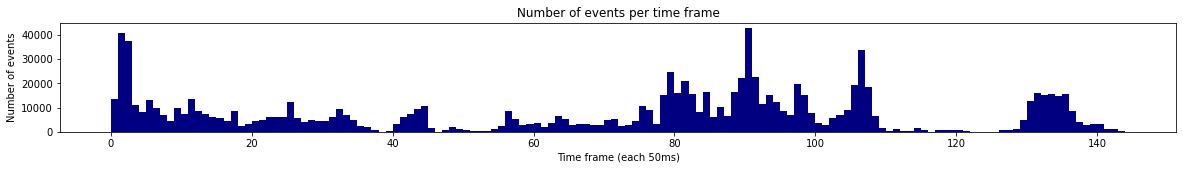

In [130]:
fig = plt.figure(figsize = (20, 2))
 
# creating the bar plot
plt.bar(list(range(number_of_buckets)), event_counts_per_bucket, color='navy', width=1.0, align="edge")
 
plt.xlabel(f"Time frame (each {BUCKET_WIDTH_T//1000}ms)")
plt.ylabel("Number of events")
plt.title("Number of events per time frame")
plt.show()


## Project Trajectory to 2D plane: Only use (t,x) or (t,y)

In [73]:
def get_projected_heatmap(df, col1, col2, width):
    df_proj = df.loc[:,[col1, col2]]

    t_max = df_proj.at[len(df_proj[col1])-1, col1]
    # [[xmin, xmax], [ymin, ymax]]
    ty_hist_range = [ [0, int(t_max)], [0, width] ]

    heatmap, xedges, yedges = np.histogram2d(df_proj[col1], df_proj[col2], bins=[number_of_buckets*T_BINS_PER_BUCKET, width], density=False, range=ty_hist_range)
    heatmap = heatmap.T
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    # heatmap = np.log2(heatmap+1)

    return df_proj, heatmap, extent

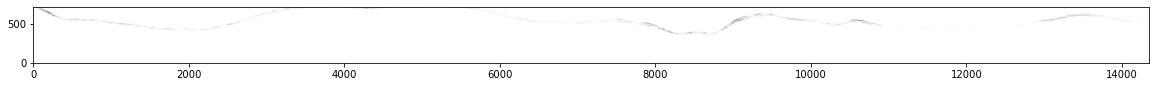

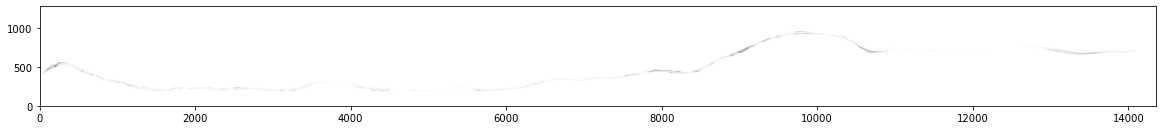

In [74]:
ty_df, ty_heatmap, ty_extent = get_projected_heatmap(df, "t", "y", HEIGHT)
log_ty_heatmap = np.log2(ty_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_ty_heatmap, extent=ty_extent, origin='upper', cmap="Greys")
plt.show()

tx_df, tx_heatmap, tx_extent = get_projected_heatmap(df, "t", "x", WIDTH)
log_tx_heatmap = np.log2(tx_heatmap+1)
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(log_tx_heatmap, extent=tx_extent, origin='upper', cmap="Greys")
plt.show()

Wie ty und tx kombinieren?
x und y range auf 0 bis 1 normalisieren, dann x*y rechnen?

## Combined chart

In [193]:
# colors for bars in events histogram
bar_colors = []
good_number = 4096
for x in event_counts_per_bucket:
    if x >= good_number*2:
        bar_colors.append("navy")
    elif x >= good_number:
        bar_colors.append("royalblue")
    elif x >= good_number//2:
        bar_colors.append("orange")
    else:
        bar_colors.append("tomato")

<BarContainer object of 144 artists>

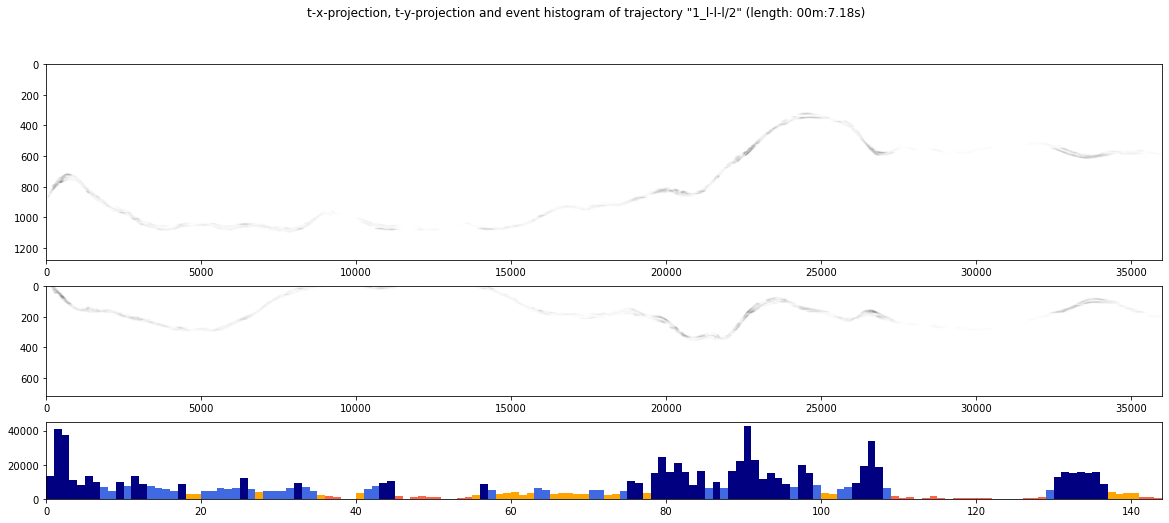

In [194]:



fig, axs = plt.subplots(3, gridspec_kw={'height_ratios': [1280,720,500]})
fig.set_size_inches(20, 8)
# fig.set_figwidth(20)
fig.suptitle(f't-x-projection, t-y-projection and event histogram of trajectory "1_l-l-l/2" (length: {max_t_str})')

axs[0].imshow(log_tx_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[1].imshow(log_ty_heatmap, origin='upper', cmap="Greys", aspect="auto")

axs[2].set_xlim(left=0, right=number_of_buckets)
axs[2].bar(list(range(number_of_buckets)), event_counts_per_bucket, width=1.0, align="edge", color=bar_colors)


-> Histogramm ist wie erste Ableitung von t-y-Projektion! 

ACHTUNG: Projektion is kopfüber!

## Export part of projected trajectory as pretty image
### First find bbox around used part of the image

In [120]:
# Return bbox indices of bbox around all non zero values
def arg_bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    ymin, ymax = np.nonzero(rows)[0][[0, -1]]
    xmin, xmax = np.nonzero(cols)[0][[0, -1]]
    return ymin, ymax+1, xmin, xmax+1

def hist2d_to_rgb(arr):
    max_val_ln = np.log(arr.max()+1)
    # log1p is ln(x+1)
    arr = np.log1p(arr) / max_val_ln # -> [0, 1]
    # make 0=white (=255), 1=black (=0)
    arr = ((arr * -1) + 1.0) * 255.0
    return arr

In [117]:

arr = np.array([0,1,2,3,4,5,6,7])

max_val_ln = np.log(arr.max()+1)
# log1p is ln(x+1)
arr = np.log1p(arr) / max_val_ln # -> [0, 1]
print(arr)
arr = ((arr * -1) + 1.0) * 255.0
print(arr)

[0.    0.333 0.528 0.667 0.774 0.862 0.936 1.   ]
[255.    170.    120.278  85.     57.636  35.278  16.375   0.   ]


0 96 0 250
[[1. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
shape (96, 250) float64
0.0 221.03897879314357 255.0
[[148.985 148.985 255.    ... 255.    255.    255.   ]
 [118.025 255.    209.342 ... 255.    255.    255.   ]
 [148.985 182.633 209.342 ... 255.    255.    255.   ]
 ...
 [255.    255.    255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]
 [255.    255.    255.    ... 255.    255.    255.   ]]


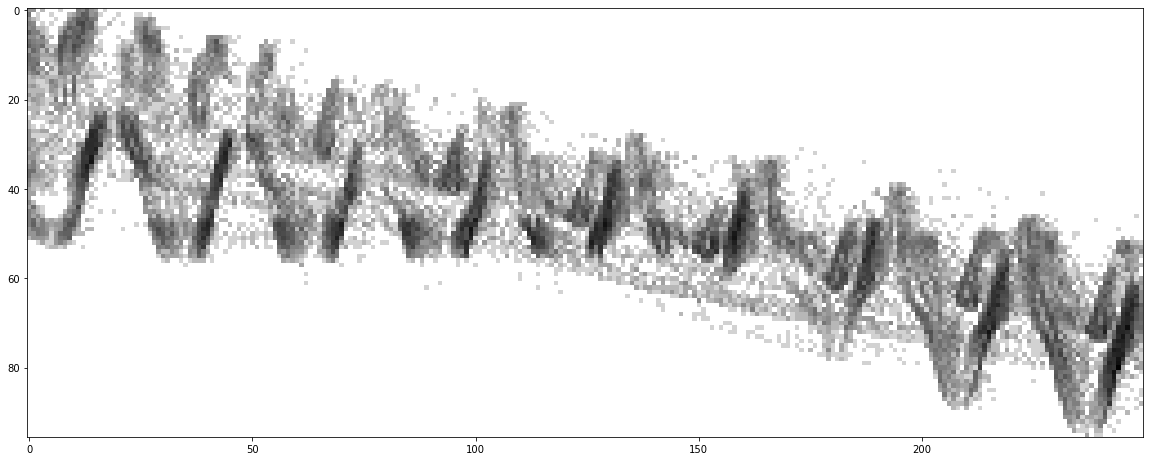

In [176]:

t_start = T_BINS_PER_BUCKET*1
ty_heatmap_tcrop = ty_heatmap[:,t_start:t_start+T_BINS_PER_BUCKET*1]

# print(ty_heatmap.shape)
# print(ty_heatmap)
# print(np.argmax(ty_heatmap, axis=0)) # findet pro spalte den 
# print(np.argmax(ty_heatmap, axis=0).shape)
# print(np.argmax(ty_heatmap, axis=1).shape)

# Crop to used area
ymin, ymax, xmin, xmax = arg_bbox(ty_heatmap_tcrop)
print(ymin, ymax, xmin, xmax)
ty_heatmap_tycrop = ty_heatmap_tcrop[ymin:ymax,:]

nonzero_mask = (ty_heatmap_tycrop != 0).astype(float)
zero_mask = (ty_heatmap_tycrop == 0).astype(float)
print(nonzero_mask)

# ty_heatmap_tycrop = np.log1p(ty_heatmap_tycrop)
# ty_heatmap_tycrop = np.log10(np.minimum(ty_heatmap_tycrop + zero_mask, 10)) * nonzero_mask

ty_heatmap_tycrop = hist2d_to_rgb(ty_heatmap_tycrop)

print("shape", ty_heatmap_tycrop.shape, ty_heatmap_tycrop.dtype)
print(ty_heatmap_tycrop.min(), ty_heatmap_tycrop.mean(), ty_heatmap_tycrop.max())
print(ty_heatmap_tycrop)

# Show image
plt.figure(figsize = (20, 10))
# plt.xlim(left=0, right=number_of_buckets)
plt.imshow(ty_heatmap_tycrop, origin='upper', cmap="gray")
plt.show()

# Save image with OpenCV
filename = "orig_res_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/trajectory_images/" + filename
cv2.imwrite(filepath, ty_heatmap_tycrop) # muss rgb sein?

# Save with PLT
filename = "plt_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".png"
filepath = "output/trajectory_images/" + filename
fig = plt.figure(frameon=False)
ax = fig.add_subplot()
ax.imshow(ty_heatmap_tycrop, aspect='equal', interpolation="none", cmap="gray")
ax.axis('off')
ax.margins(0)
plt.savefig(filepath, format="png", bbox_inches="tight", pad_inches=0, dpi=SAVE_IMAGE_DPI)
plt.close()
